In [7]:
# !rm -rf /kaggle/working/handwriting-generator-model
# !git clone https://github.com/Shambu-K/handwriting-generator-model.git
# !pip install fastdtw
# %cd /kaggle/working/handwriting-generator-model/Code/STR_model

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [9]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx:<4} | Width: {data.shape[2]:<3} | Loss: {loss.item():.4f}')
            
    return loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, data_path, plot=True):
    train_losses = []
    for epoch in range(num_epochs):
        if plot: visualize_progress(model, device, data_path)
        print('=====================================================================\n')
        loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        train_losses.append(loss)
        scheduler.step()
        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__.__name__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 100
batch_size = 16 # Archibald it is 32
checkpoint_interval = 1
learning_rate = 0.0001
lr_decay = 0.96

print('Using device:', device)

Using device: cuda


In [11]:
# Load data
# root_dir = '/kaggle/input/iam-dataset-online/Resized_Dataset/Train'
root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, device, max_allowed_width=400)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 2649/2649 [00:39<00:00, 66.29it/s]


In [ ]:
idx = 123
dataloader = [dataset[idx][0].unsqueeze(0), dataset[idx][1].unsqueeze(0)]

In [12]:
# Model
model = STR_Model_Longer_512().to(device)
set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss(sos_weight=5)

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

Image id: 38147


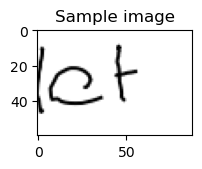

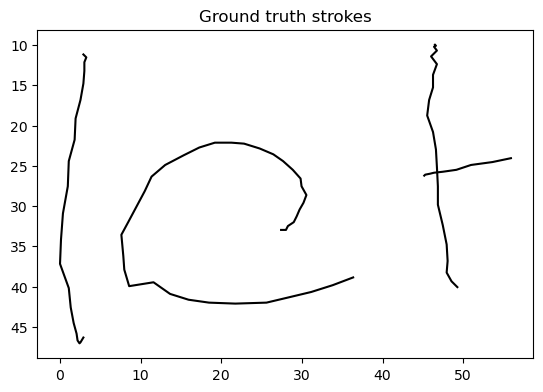

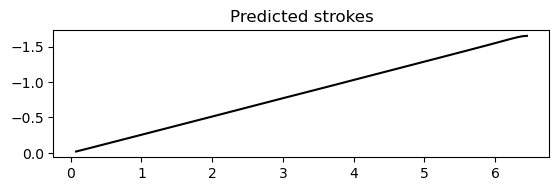

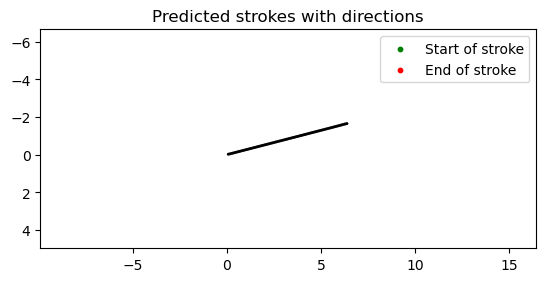

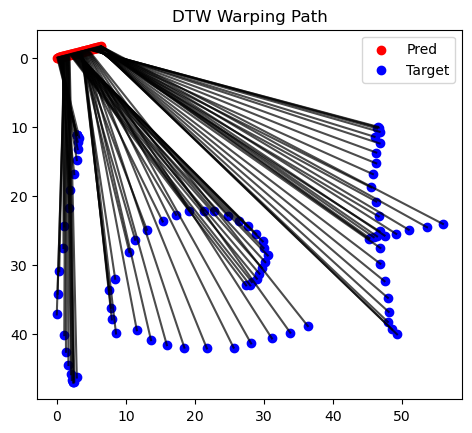

Epoch 1:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Loss: 528.6831706936607
   Batch: 100  | Loss: 346.2873132332597
   Batch: 200  | Loss: 315.8774725811307
   Batch: 300  | Loss: 313.1052475193068
   Batch: 400  | Loss: 260.14316431367257
   Batch: 500  | Loss: 352.93832767131545
   Batch: 600  | Loss: 292.65936201202317
   Batch: 700  | Loss: 367.92106078963593
   Batch: 800  | Loss: 314.6951811807645
   Batch: 900  | Loss: 426.26583644166817
   Batch: 1000 | Loss: 299.6516001830472
   Batch: 1100 | Loss: 369.45438933650695
   Batch: 1200 | Loss: 440.91003125510423
   Batch: 1300 | Loss: 385.1884303234473
   Batch: 1400 | Loss: 456.7628062000851
   Batch: 1500 | Loss: 459.9422637487672
   Batch: 1600 | Loss: 434.1101154099651
   Batch: 1700 | Loss: 513.4260724853359
   Batch: 1800 | Loss: 476.6461226033142
   Batch: 1900 | Loss: 534.0254781852664
   Batch: 2000 | Loss: 529.9234755477762
   Batch: 2100 | Loss: 571.6749306128318
   Batch: 2200 | Loss: 694.0168191437499
   Batch: 2300 | Loss: 702.9818716025018
   Batch:

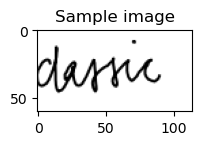

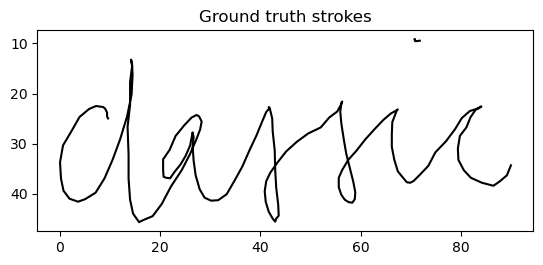

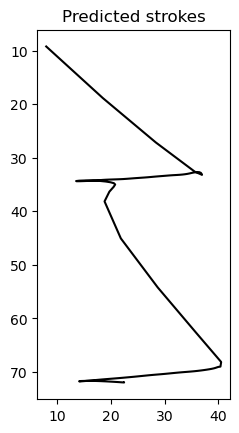

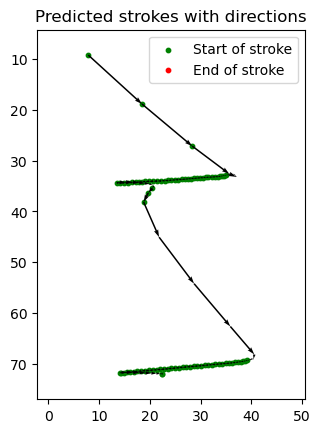

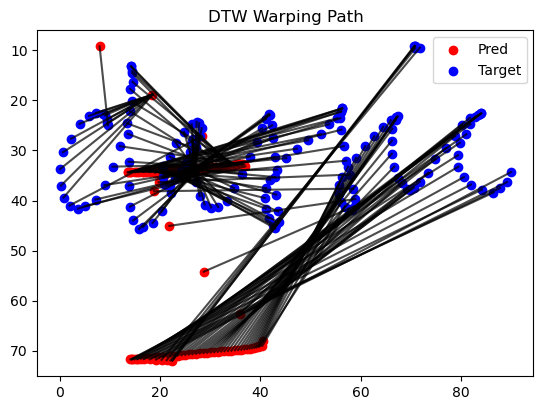

Epoch 2:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Loss: 570.5365096017675
   Batch: 100  | Loss: 300.4402093999922
   Batch: 200  | Loss: 301.67888812205655
   Batch: 300  | Loss: 280.13868644160266
   Batch: 400  | Loss: 264.76339162527677
   Batch: 500  | Loss: 260.0042704327897
   Batch: 600  | Loss: 264.2318045725066
   Batch: 700  | Loss: 333.9032115940835
   Batch: 800  | Loss: 277.29379637612635
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/taha_adeel/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_103737/3536949660.py", line 2, in <module>
    losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, root_dir, plot=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103737/3372121254.py", line 25, in model_fit
    loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103737/3372121254.py", line 10, in train
    loss = loss_function(output, target)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/taha_adeel/anaconda3/envs/tensorflow

In [ ]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, root_dir, plot=True)